# Plot energy for one MCMC run

Plot the MCMC history for a run at fixed $n_t$ and $T$.
Shoe the history and the distribution, including the thermalization phase

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_context("poster") # scale elements up or down in size

## Get the data from the `HDF5` file

All observables are in a single `data.h5` file for each MCMC run. The file includes a dataframe with information about the observables and the parameters of the run.

In [2]:
filename = f"../../lattice/improv_runs/bmn2_su3_g05/l128/t005/data.h5"
data = pd.read_hdf(filename, "mcmc_obs")

In [3]:
data.head()

,dH,e,p,x2,f2,ub,acc,nmat,ntau,xdtau,udtau,temperature,mass,coupling,tau,mdtu
tj,,,,,,,,,,,,,,,,
20,0.094968,0.870111,0.126661,0.715016,0.413587,3.108624e-14,0.950000,3,40,0.0125,0.0125,0.05,1.0,0.5,0.5,10.0
40,0.047377,0.865736,0.386852,0.698428,0.446155,2.042810e-14,0.925000,3,40,0.0125,0.0125,0.05,1.0,0.5,0.5,20.0
60,-0.155149,0.959197,0.388149,0.780708,0.475971,2.486900e-14,0.833333,3,40,0.0125,0.0125,0.05,1.0,0.5,0.5,30.0
80,0.092722,0.698018,0.265920,0.579808,0.315226,2.797762e-14,0.850000,3,40,0.0125,0.0125,0.05,1.0,0.5,0.5,40.0
100,-0.287416,0.844281,0.190934,0.651633,0.513728,2.264855e-14,0.880000,3,40,0.0125,0.0125,0.05,1.0,0.5,0.5,50.0


In [4]:
data.shape

(2100, 16)

<AxesSubplot:ylabel='Frequency'>

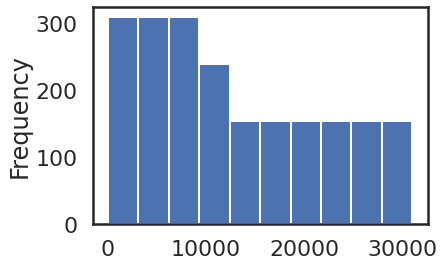

In [5]:
# different frequencies in the mdtu means different saving intervals
data.mdtu.plot.hist()

In [195]:
# do we have multiple trajectory lengths
data.tau.nunique()

1

In [196]:
# do we have multiple integration lengths
data.ntau.nunique()

2

## Plot trajectory and distribution

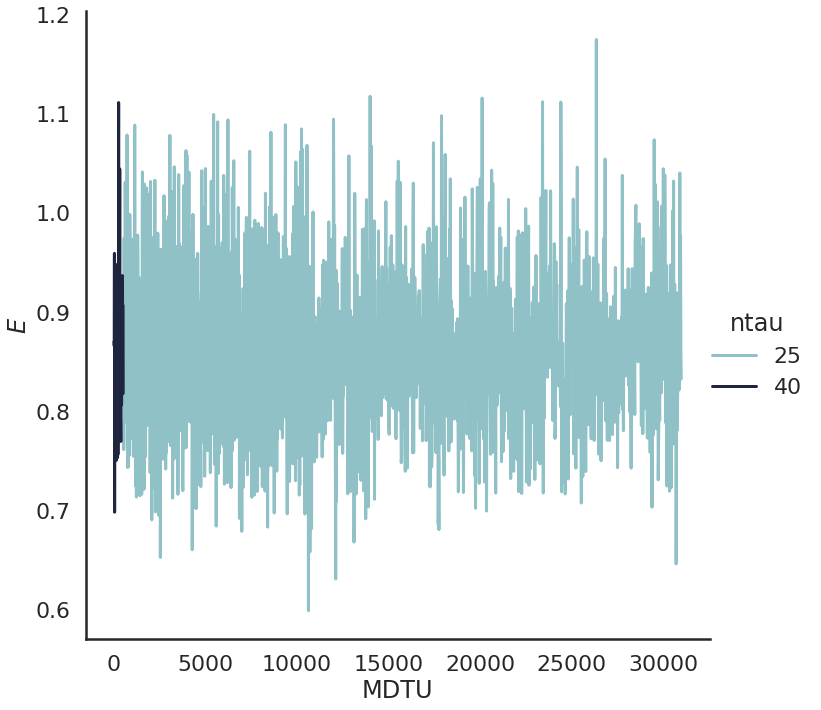

In [197]:
if data.ntau.nunique() > 1:
    pal = sns.cubehelix_palette(data.ntau.nunique(), rot=-.25, light=.7)
    g = sns.relplot(x="mdtu", y="e", hue="ntau", data=data, kind="line", palette=pal, height=10)
else:
    g = sns.relplot(x="mdtu", y="e", data=data, kind="line", height=10)
g.set_xlabels("MDTU")
g.set_ylabels(r"$E$")

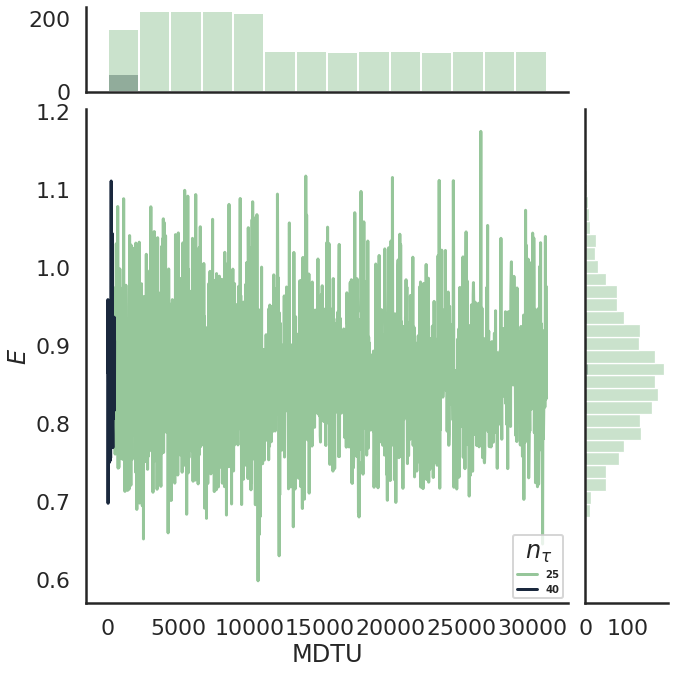

In [214]:
pal = sns.cubehelix_palette(data.ntau.nunique(), rot=-.5, light=.7)
g = sns.JointGrid(data=data, x="mdtu", y="e", hue="ntau", height=10, palette=pal, marginal_ticks=True)
# Add the joint and marginal histogram plots
g.plot_joint(sns.lineplot)
g.plot_marginals(sns.histplot)
# labels
legend_properties = {'weight':'bold','size':10}
g.ax_joint.legend(prop=legend_properties,facecolor='white',loc='lower right', title=r"$n_\tau$")
g.set_axis_labels(xlabel="MDTU", ylabel=r"$E$")

## Plot joint distributions

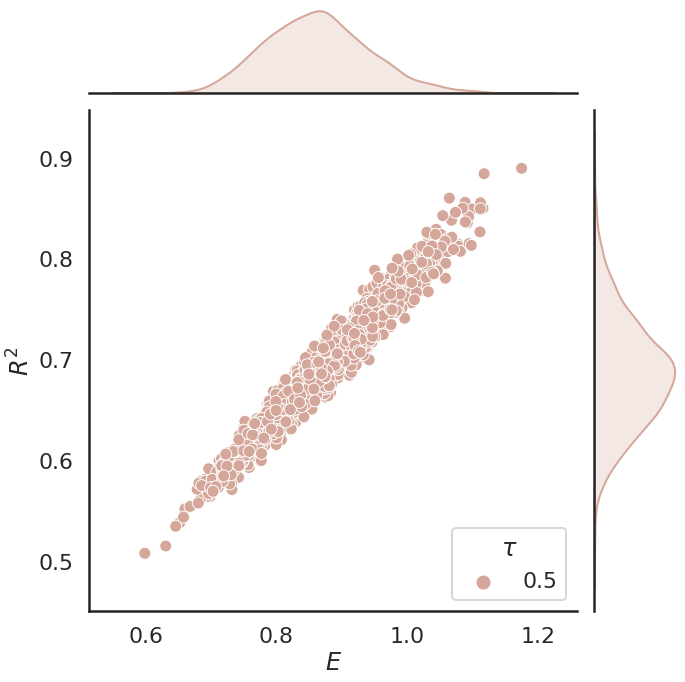

In [221]:
pal = sns.cubehelix_palette(data.tau.nunique(), rot=.5, light=.7)
g = sns.jointplot(data=data, x="e", y="x2", hue="tau", palette=pal, height=10)
# labels
g.ax_joint.legend(facecolor='white',loc='lower right', title=r"$\tau$")
g.set_axis_labels(xlabel=r"$E$", ylabel=r"$R^2$")
# save for web 
g.savefig("test.svg")


## Make a function to create plots for each run

We want to make the joint plots for each available run

In [6]:
def make_joint_plot_e_mdtu(
    run: str = "../../lattice/improv_runs/bmn2_su3_g05/l16/t04",
    outputdir: str = "../figures",
    outputfmt: str = "svg"
):
    # read data from disk
    try:
        filename = f"{run}/data.h5"
        data = pd.read_hdf(filename, "mcmc_obs")
    except (ValueError, FileNotFoundError) as e:
        print(f"{e} . Skipping...")
        return
    # color palette
    pal = sns.cubehelix_palette(data.ntau.nunique(), rot=-.5, light=.7)
    g = sns.JointGrid(data=data, x="mdtu", y="e", hue="ntau", height=10, palette=pal, marginal_ticks=True)
    # Add the joint and marginal histogram plots
    g.plot_joint(sns.lineplot)
    g.plot_marginals(sns.histplot)
    # labels
    legend_properties = {'weight':'bold','size':10}
    g.ax_joint.legend(prop=legend_properties,facecolor='white',loc='lower right', title=r"$n_\tau$")
    g.set_axis_labels(xlabel="MDTU", ylabel=r"$E$")
    # save
    names = run.split('/')
    outputfile = f"{outputdir}/{names[-3]}_{names[-2]}_{names[-1]}_energy-mdtu.{outputfmt}"
    g.savefig(outputfile)


Call the function for each MCMC run

../../lattice/improv_runs/bmn2_su2_g05/l16/t005
../../lattice/improv_runs/bmn2_su2_g05/l16/t01
../../lattice/improv_runs/bmn2_su2_g05/l16/t025
../../lattice/improv_runs/bmn2_su2_g05/l16/t02
../../lattice/improv_runs/bmn2_su2_g05/l16/t04
../../lattice/improv_runs/bmn2_su2_g05/l16/t015
../../lattice/improv_runs/bmn2_su2_g05/l16/t03
../../lattice/improv_runs/bmn2_su2_g05/l32/t005
../../lattice/improv_runs/bmn2_su2_g05/l32/t0025
File ../../lattice/improv_runs/bmn2_su2_g05/l32/t0025/data.h5 does not exist . Skipping...
../../lattice/improv_runs/bmn2_su2_g05/l32/t01
../../lattice/improv_runs/bmn2_su2_g05/l32/t025
../../lattice/improv_runs/bmn2_su2_g05/l32/t02
../../lattice/improv_runs/bmn2_su2_g05/l32/t04
../../lattice/improv_runs/bmn2_su2_g05/l32/t015
../../lattice/improv_runs/bmn2_su2_g05/l32/t001
File ../../lattice/improv_runs/bmn2_su2_g05/l32/t001/data.h5 does not exist . Skipping...
../../lattice/improv_runs/bmn2_su2_g05/l32/t03
../../lattice/improv_runs/bmn2_su2_g05/l48/t005
../../latt

/home/enrico/miniconda3/envs/lattice-fits/lib/python3.9/site-packages/seaborn/axisgrid.py:1598: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


../../lattice/improv_runs/bmn2_su2_g05/l192/t005
../../lattice/improv_runs/bmn2_su2_g05/l192/t01
../../lattice/improv_runs/bmn2_su2_g05/l192/t025
../../lattice/improv_runs/bmn2_su2_g05/l192/t02
../../lattice/improv_runs/bmn2_su2_g05/l192/t04
../../lattice/improv_runs/bmn2_su2_g05/l192/t015
../../lattice/improv_runs/bmn2_su2_g05/l192/t03
../../lattice/improv_runs/bmn2_su2_g05/l24/t005
../../lattice/improv_runs/bmn2_su2_g05/l24/t0025
File ../../lattice/improv_runs/bmn2_su2_g05/l24/t0025/data.h5 does not exist . Skipping...
../../lattice/improv_runs/bmn2_su2_g05/l24/t01
../../lattice/improv_runs/bmn2_su2_g05/l24/t025
../../lattice/improv_runs/bmn2_su2_g05/l24/t02
../../lattice/improv_runs/bmn2_su2_g05/l24/t04
../../lattice/improv_runs/bmn2_su2_g05/l24/t015
../../lattice/improv_runs/bmn2_su2_g05/l24/t001
File ../../lattice/improv_runs/bmn2_su2_g05/l24/t001/data.h5 does not exist . Skipping...
../../lattice/improv_runs/bmn2_su2_g05/l24/t03
../../lattice/improv_runs/bmn2_su2_g05/l96/t005
../

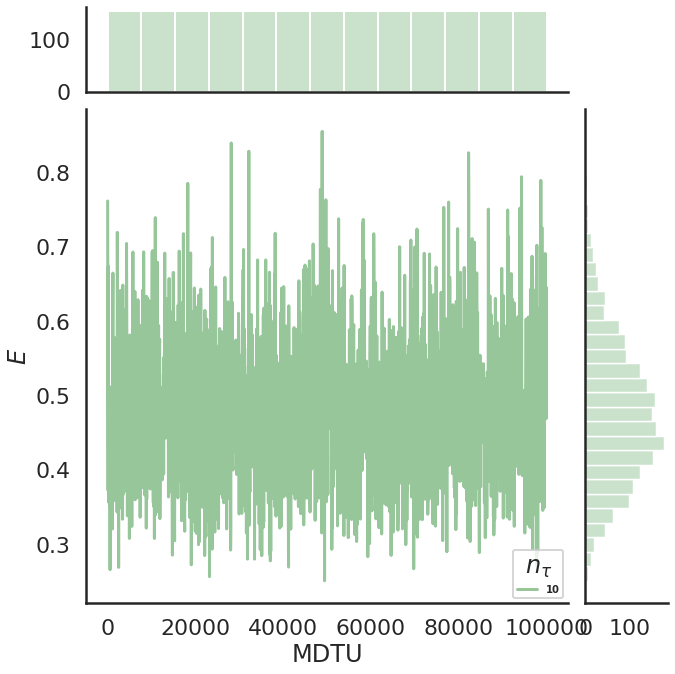

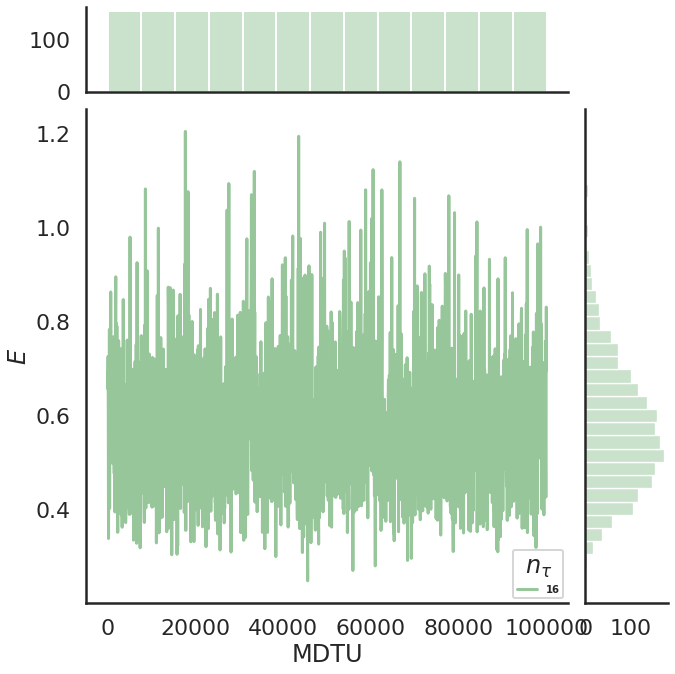

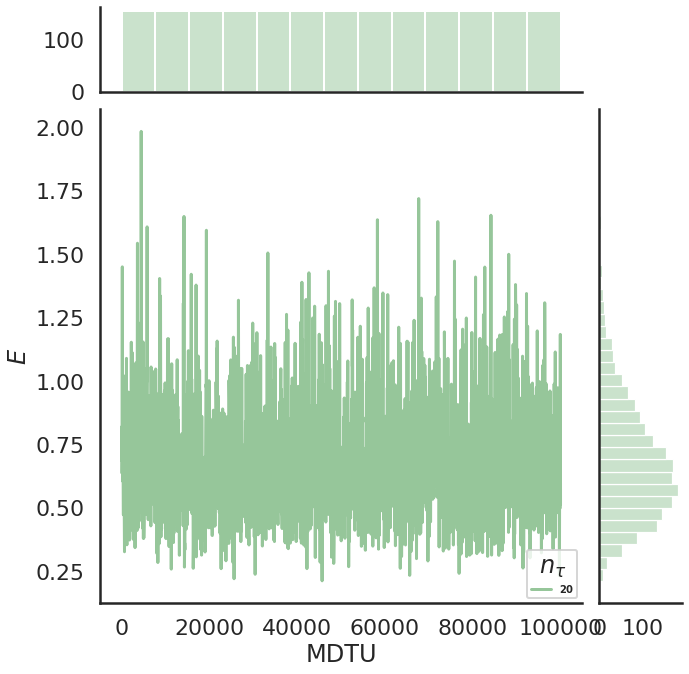

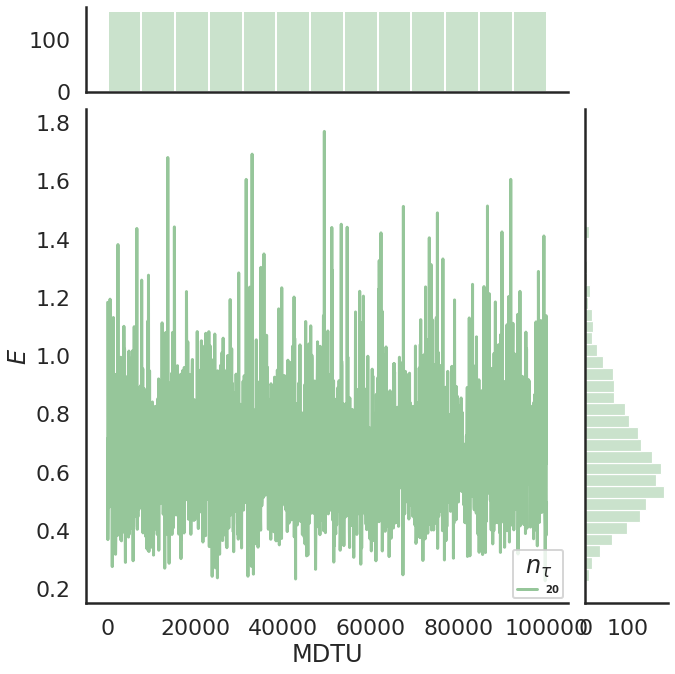

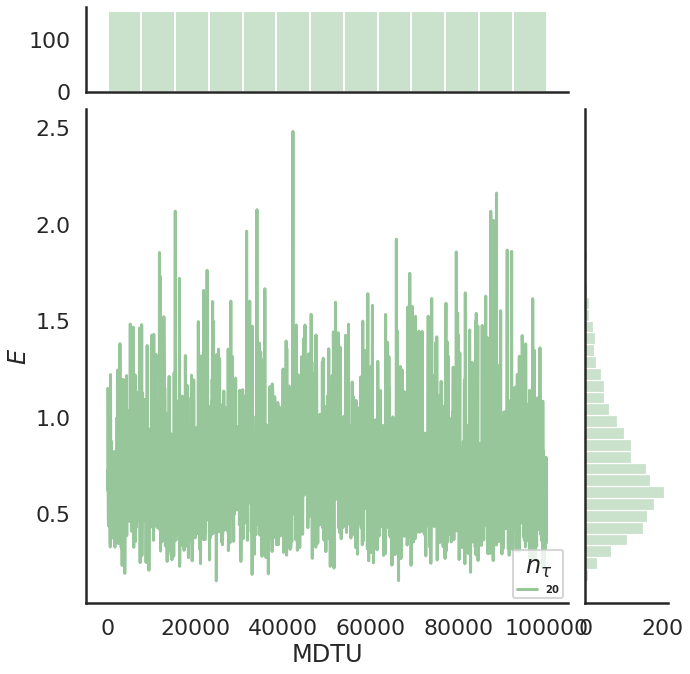

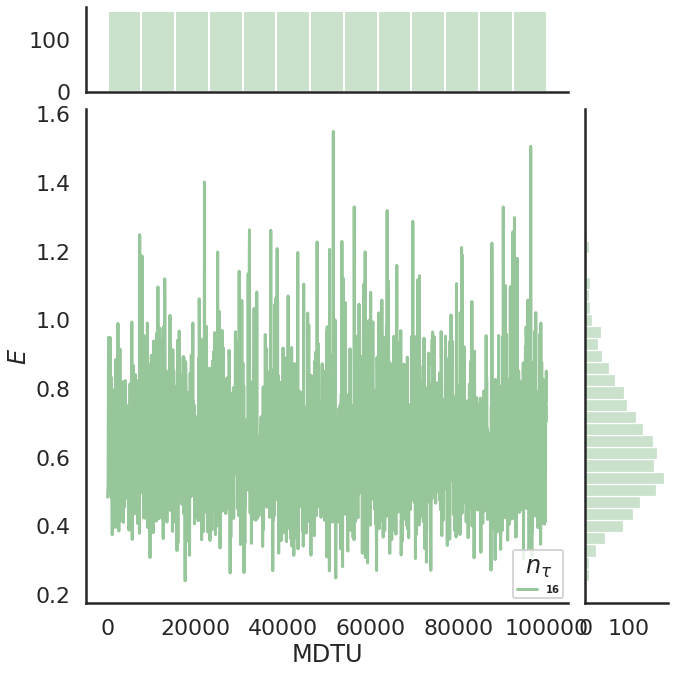

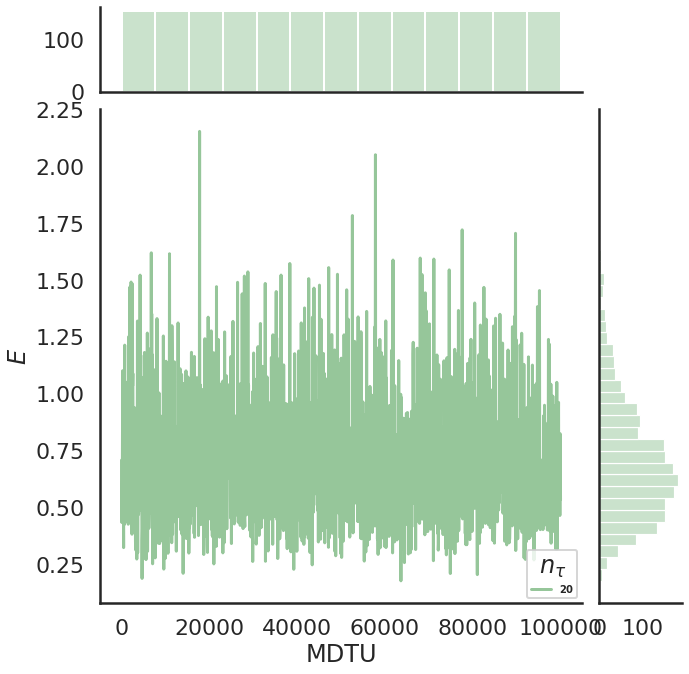

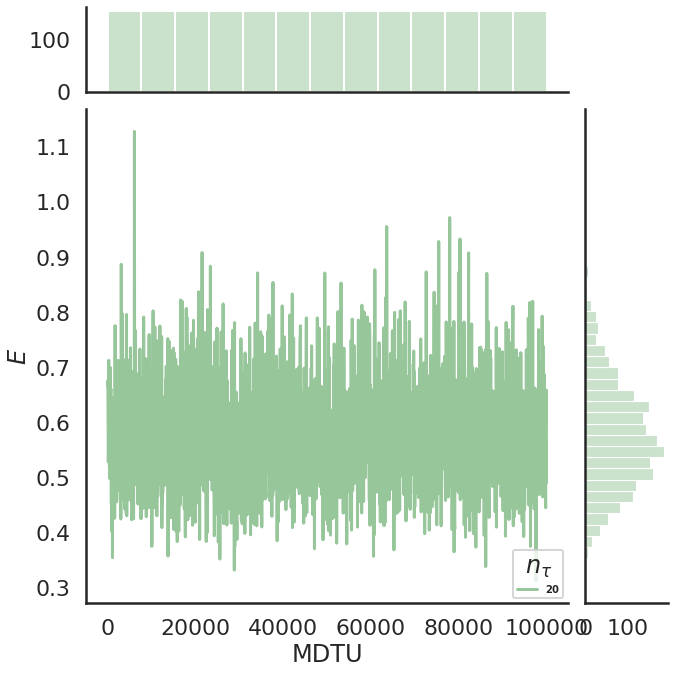

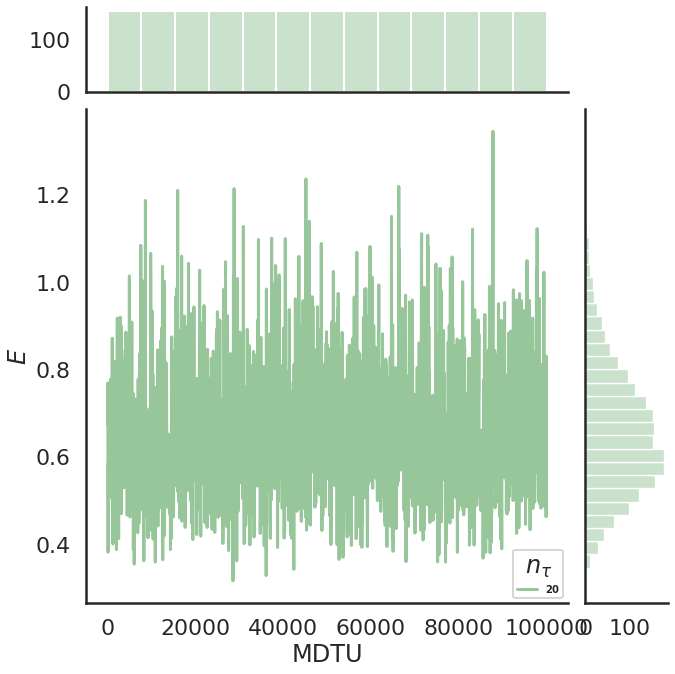

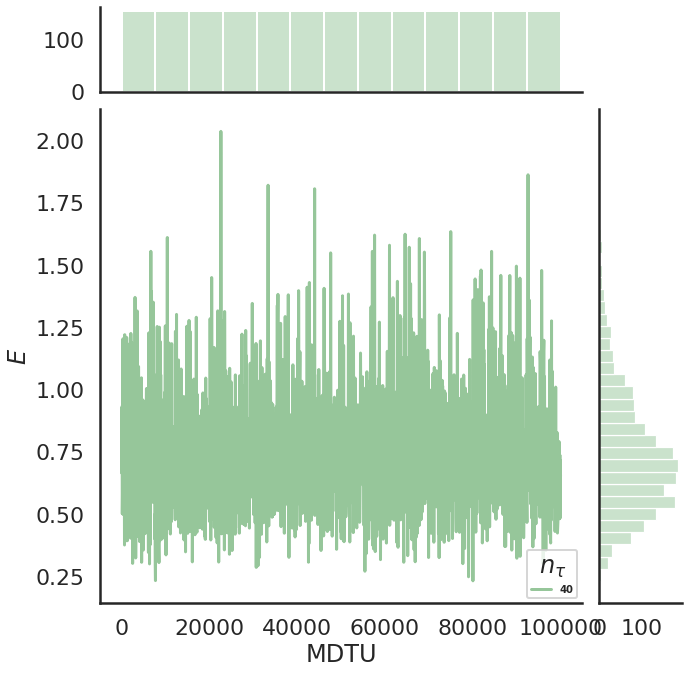

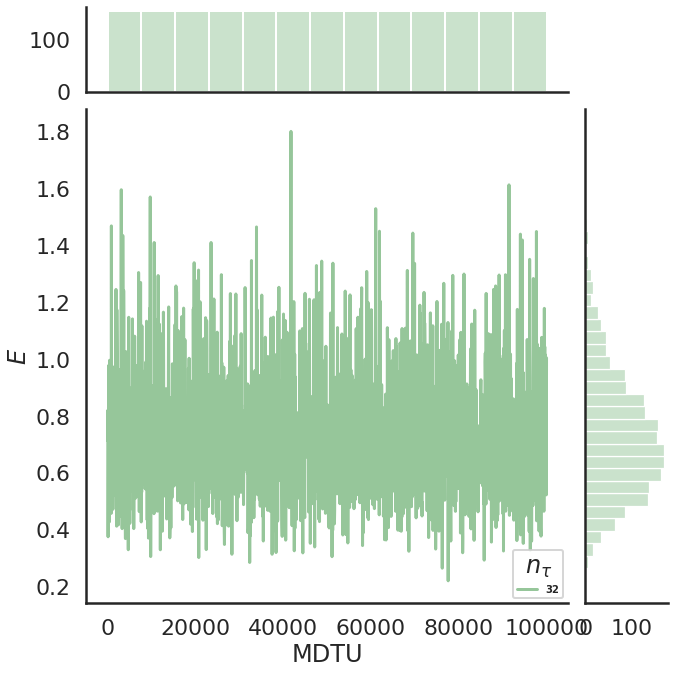

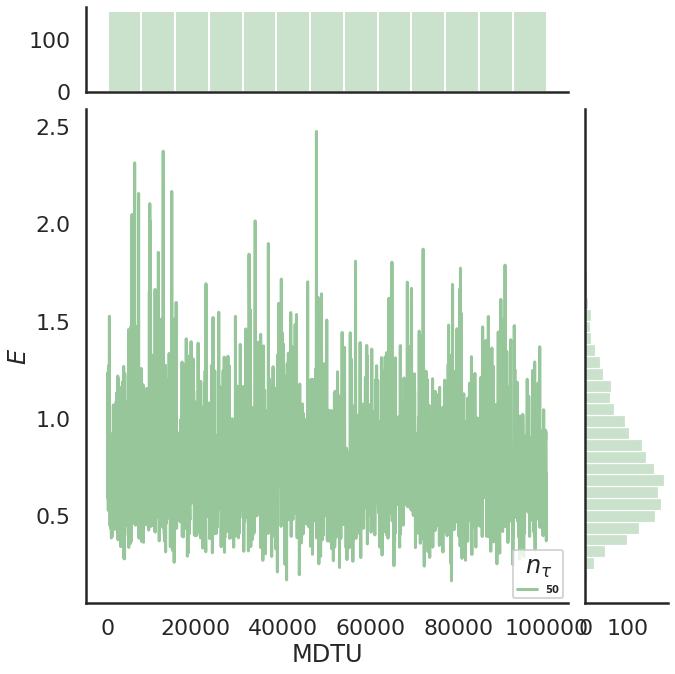

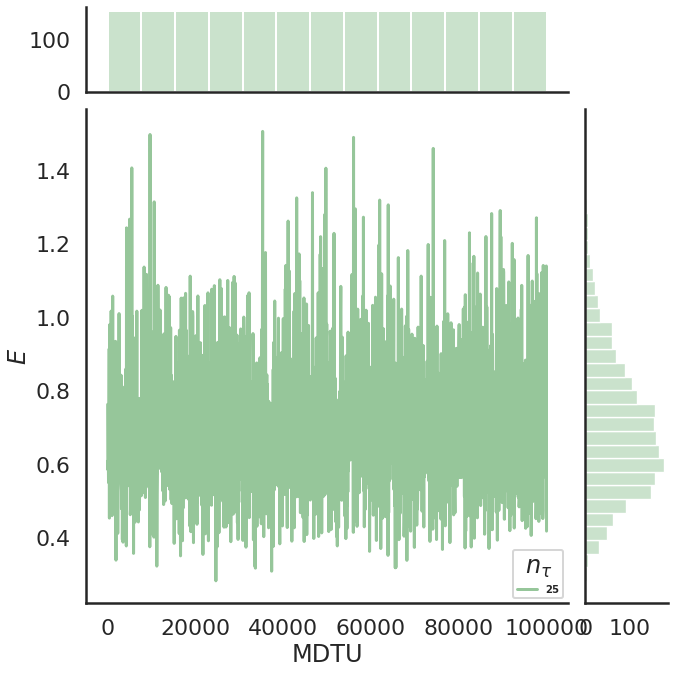

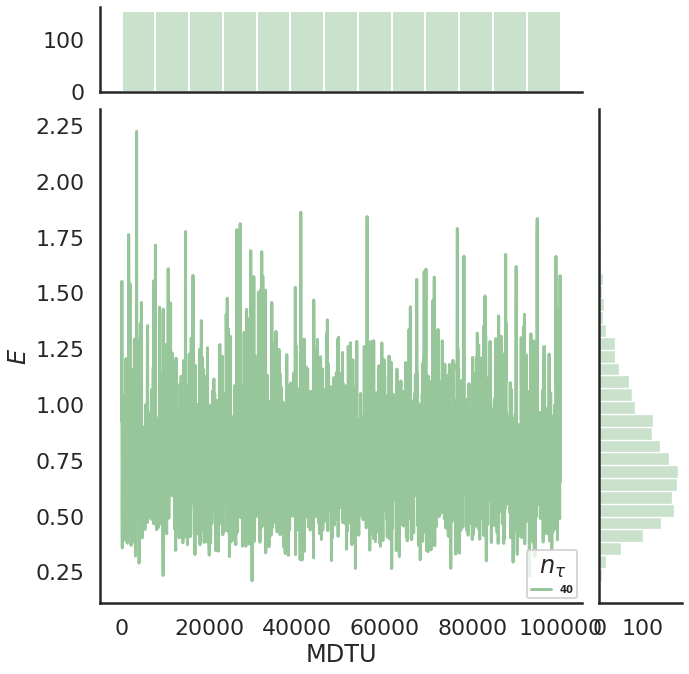

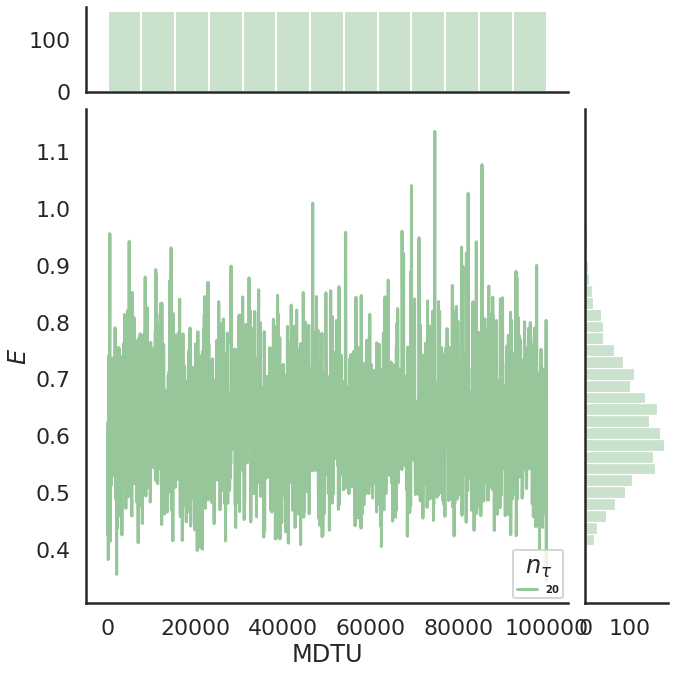

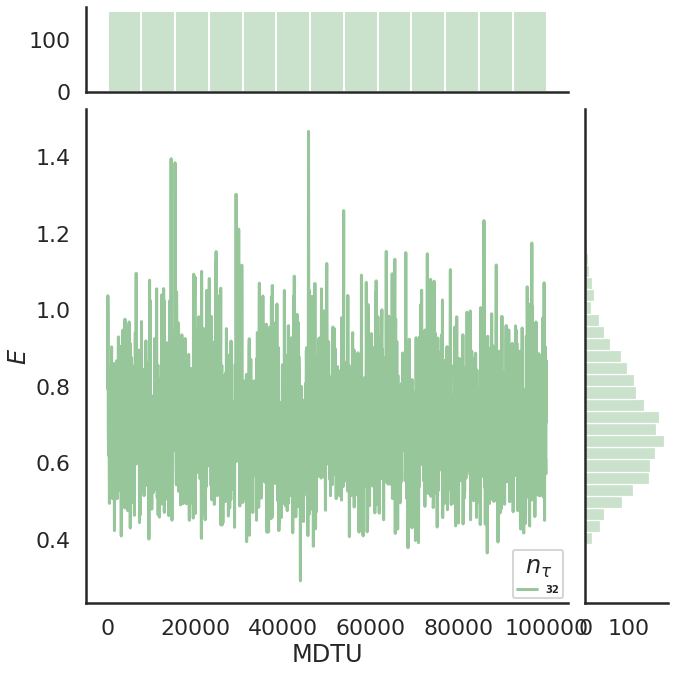

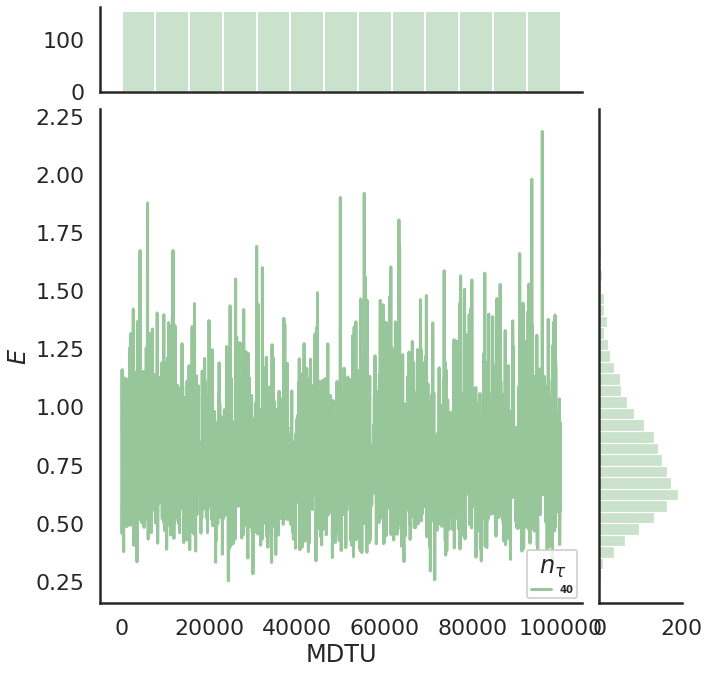

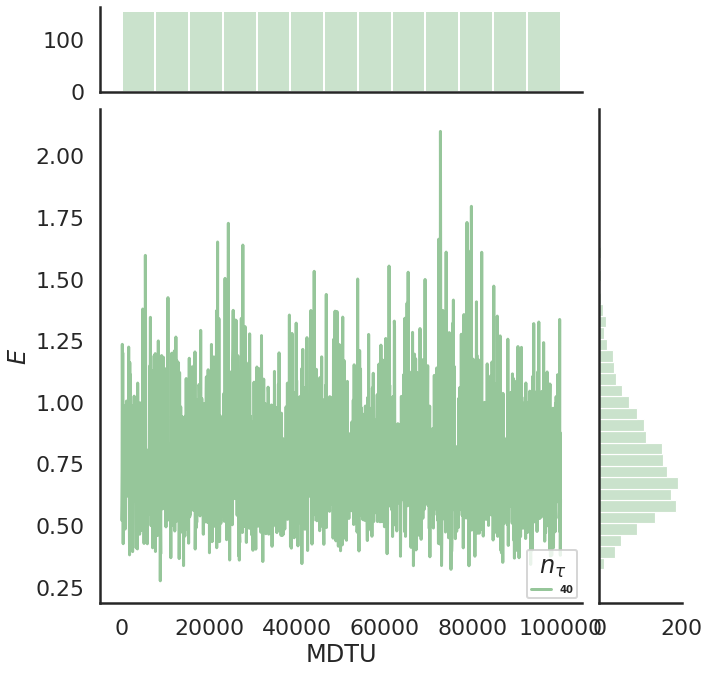

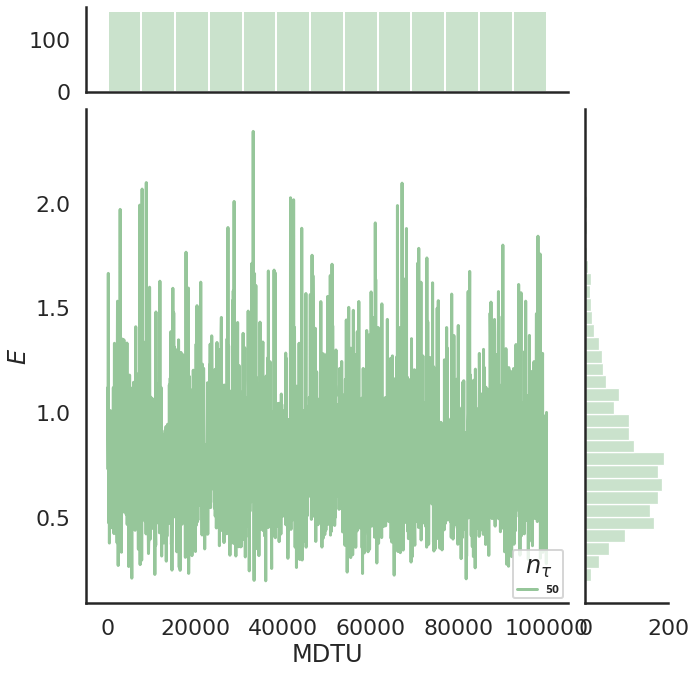

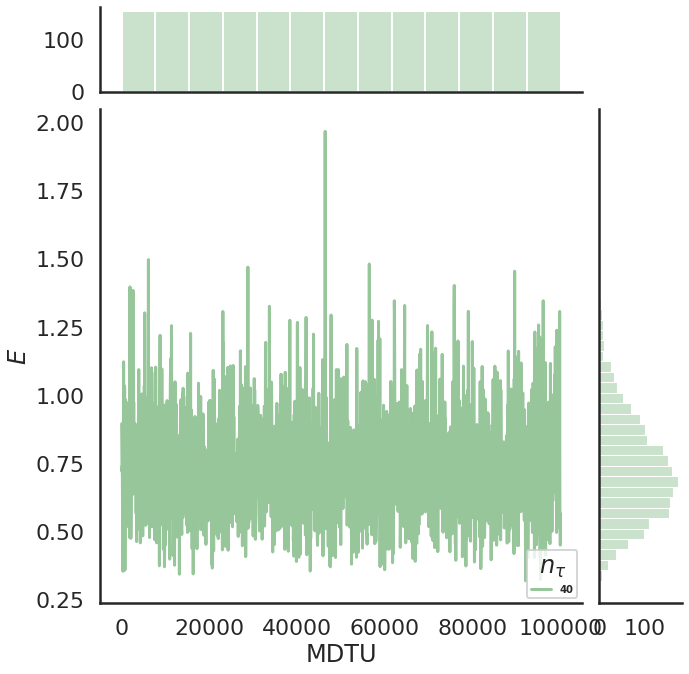

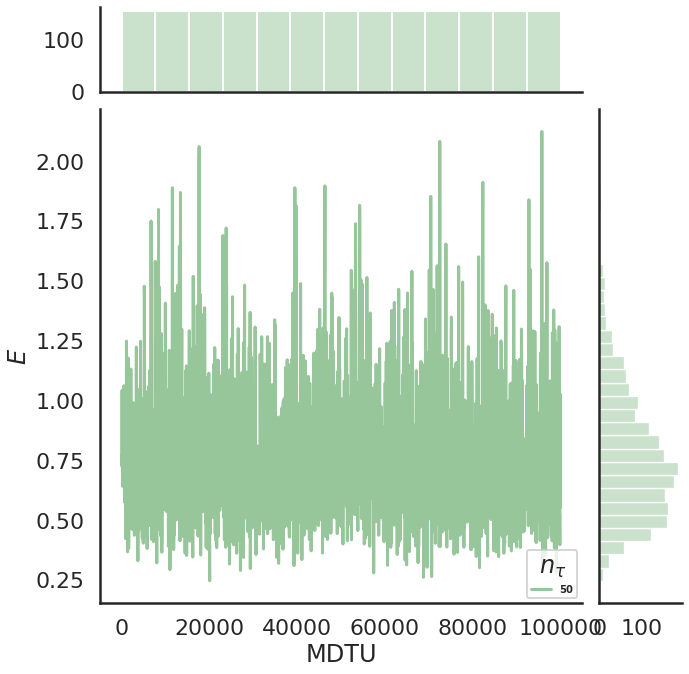

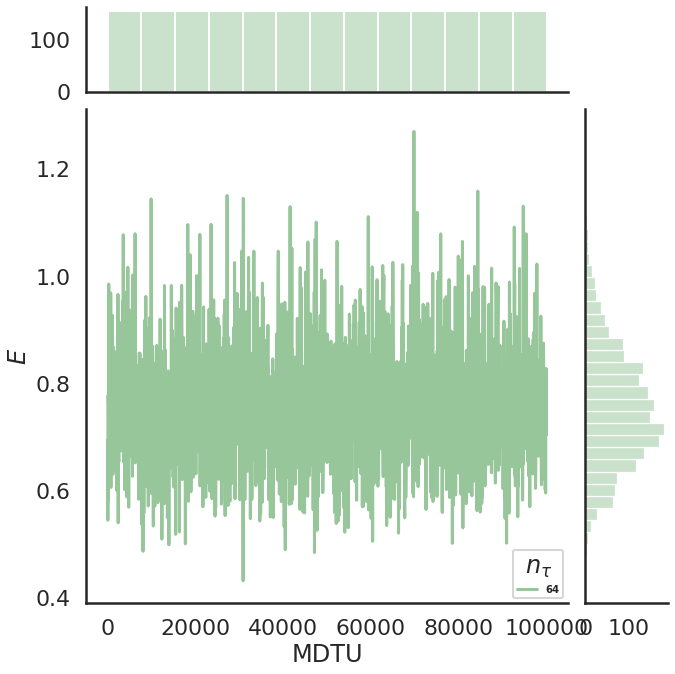

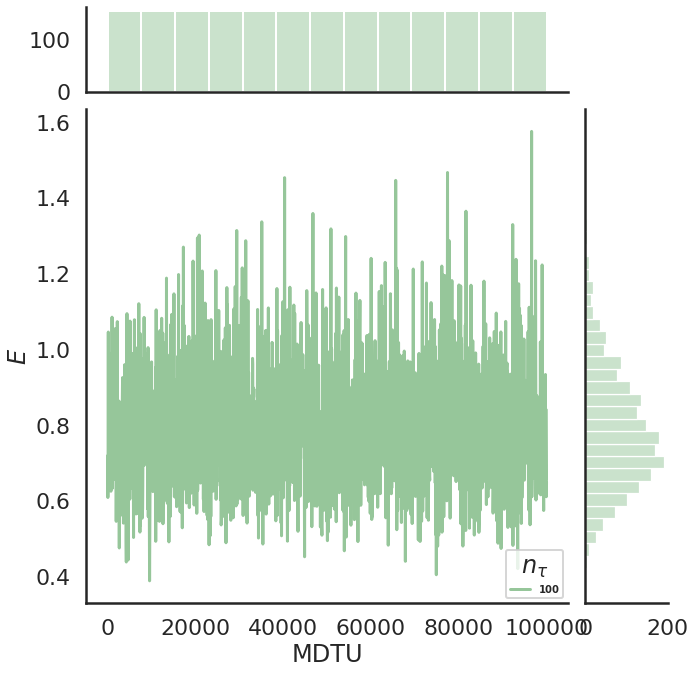

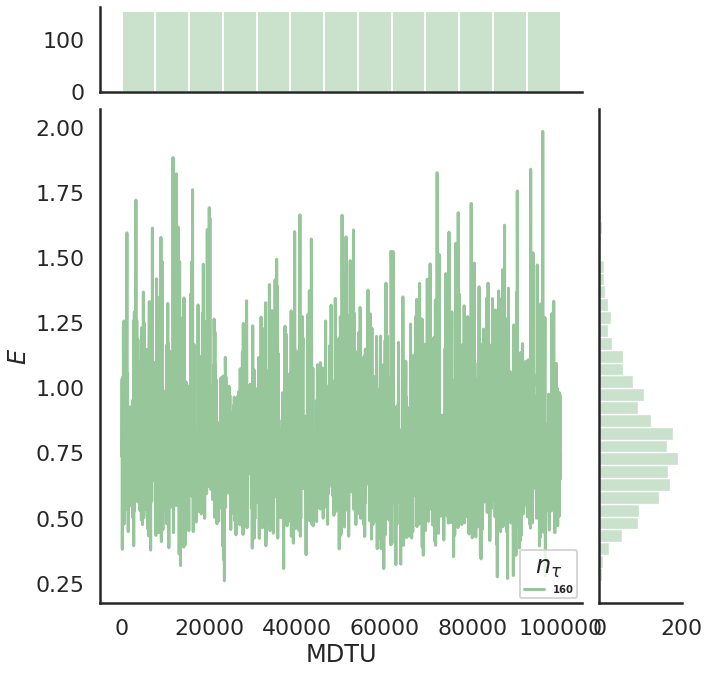

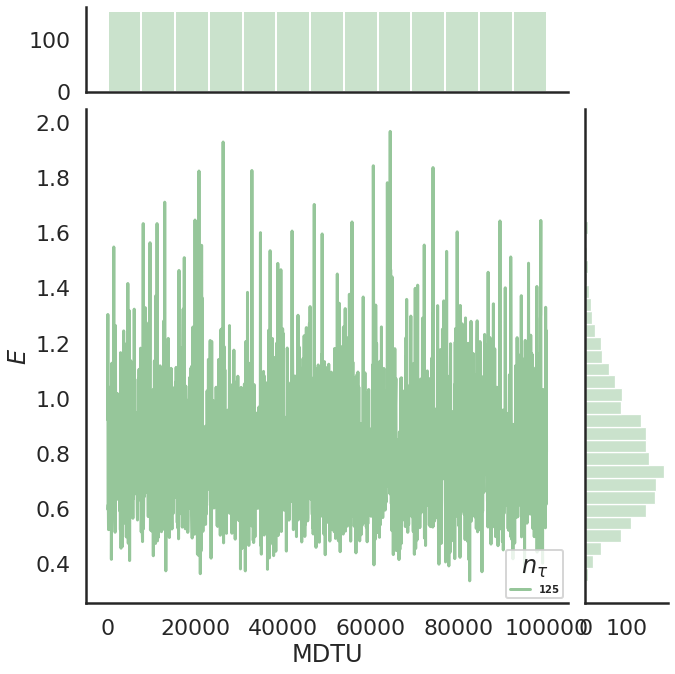

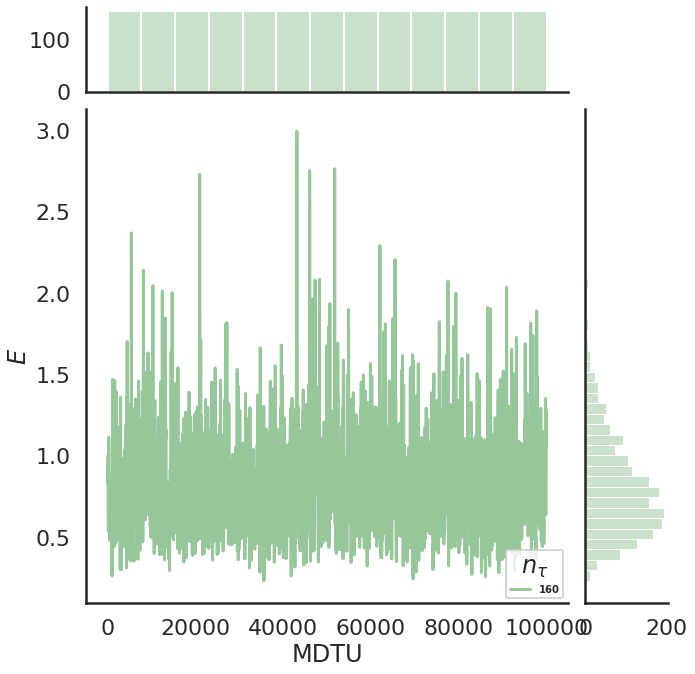

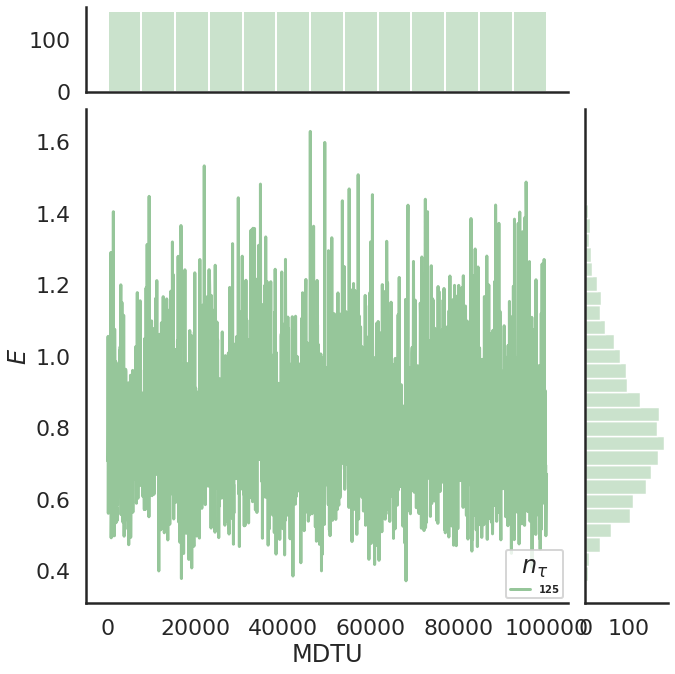

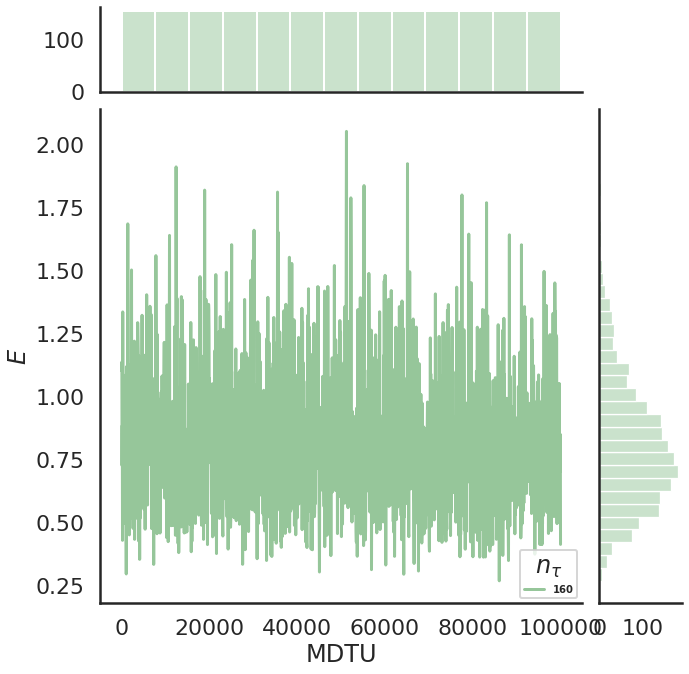

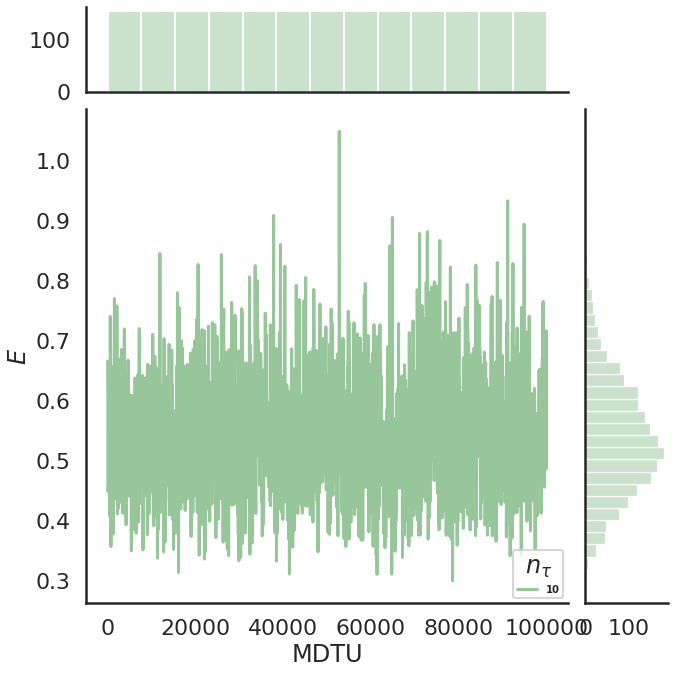

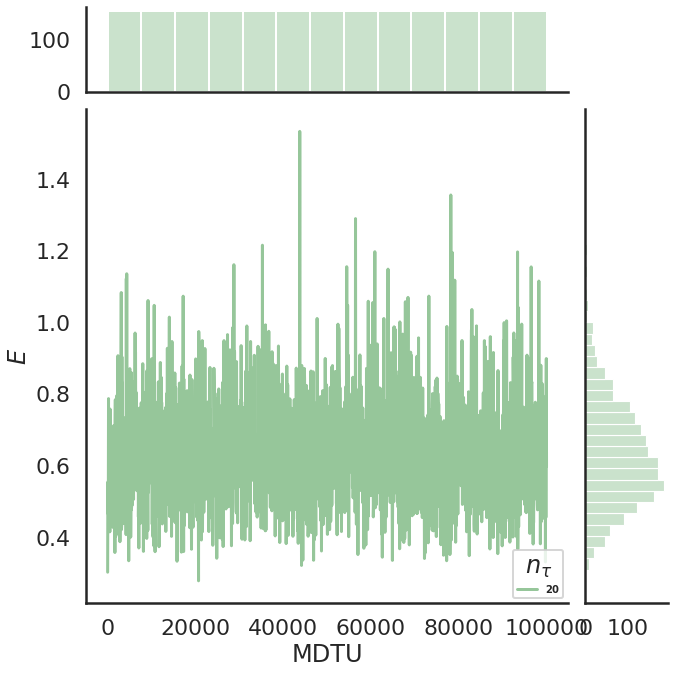

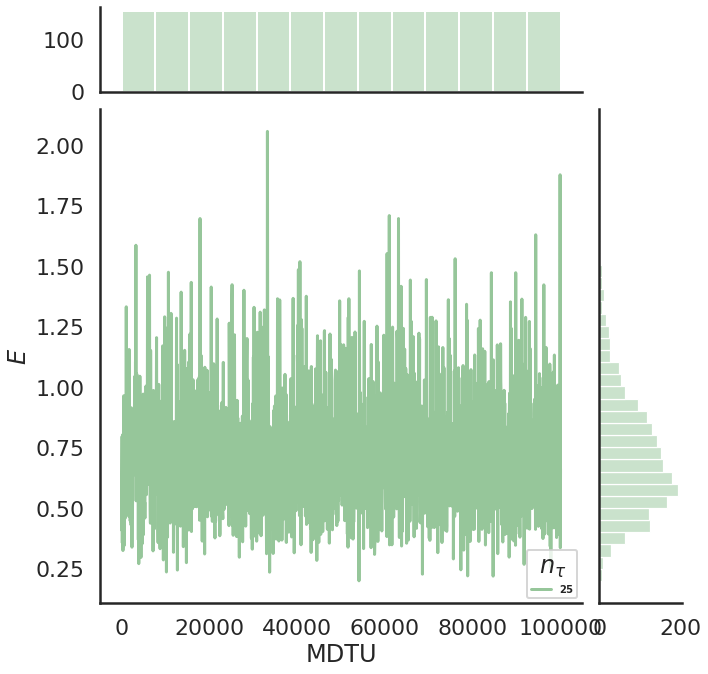

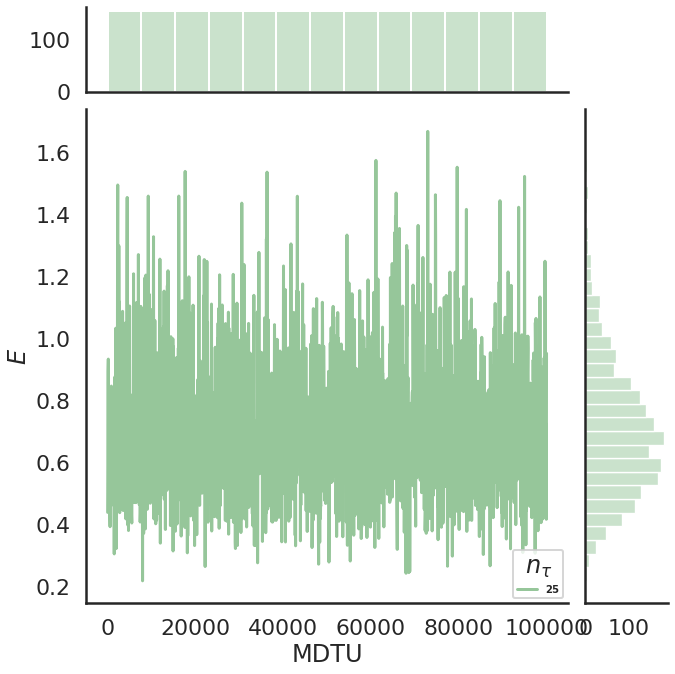

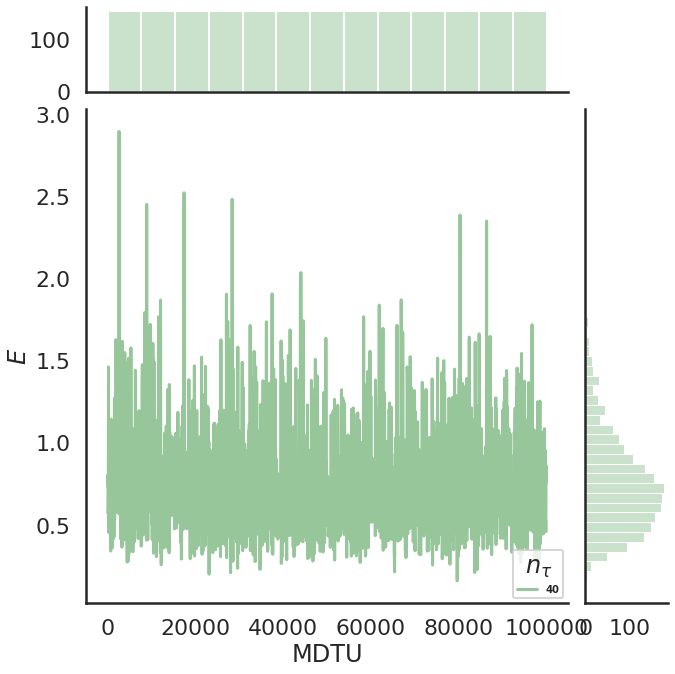

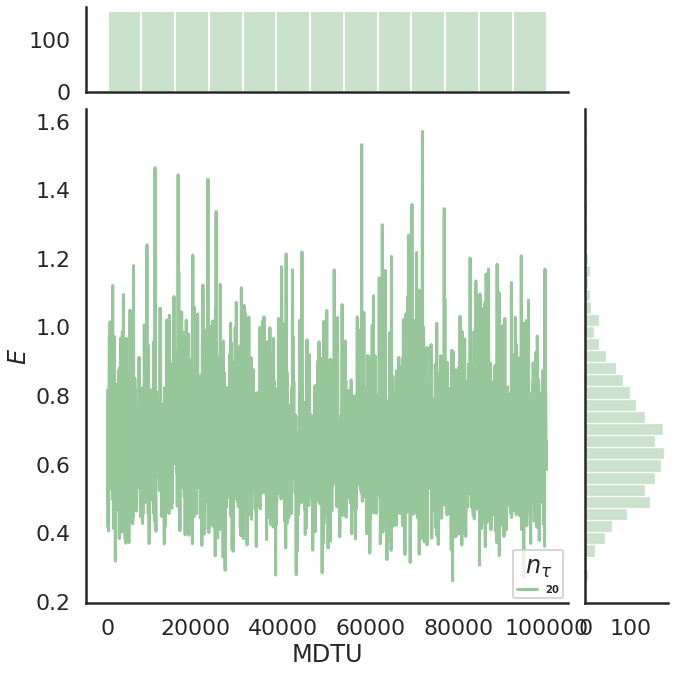

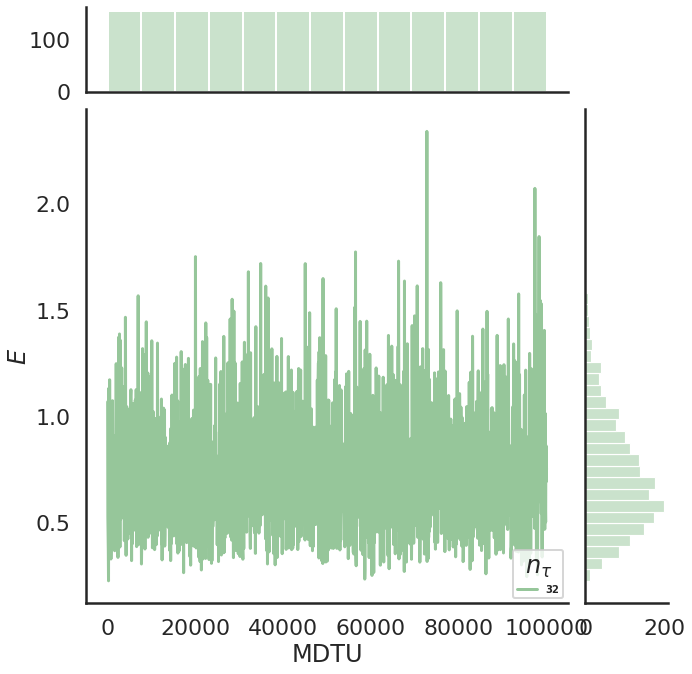

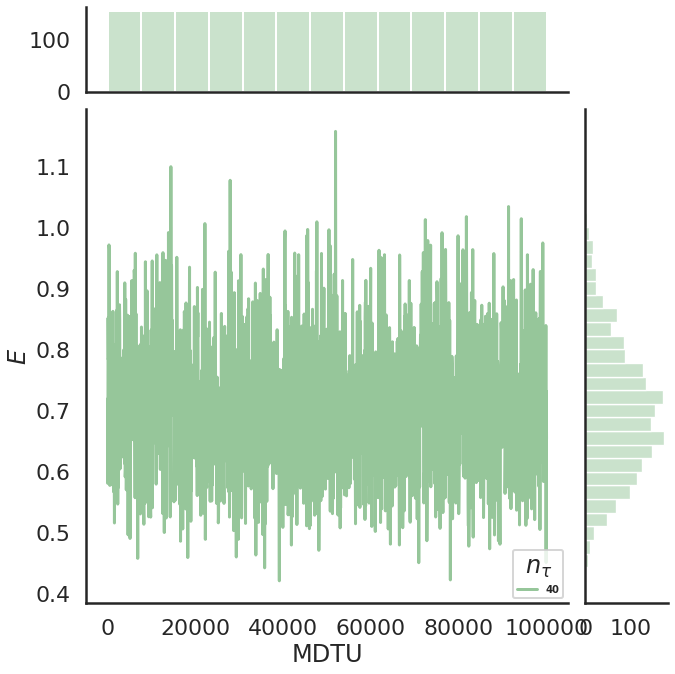

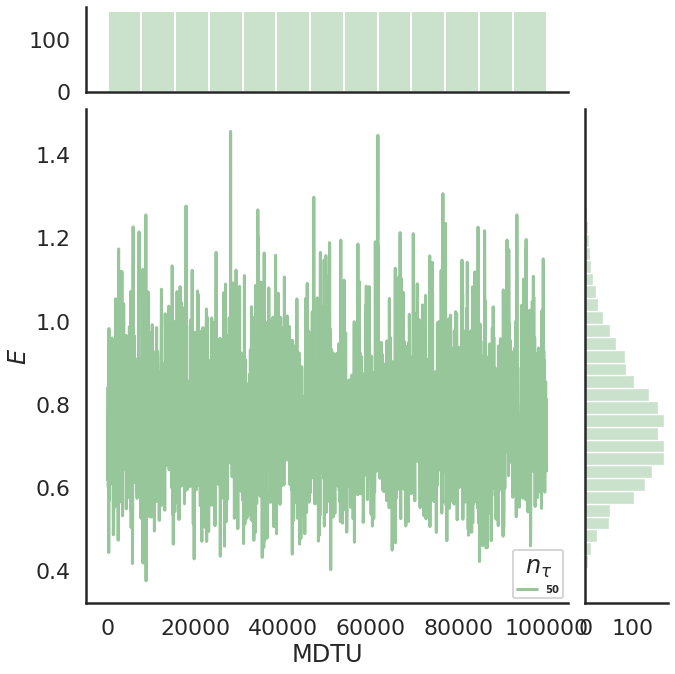

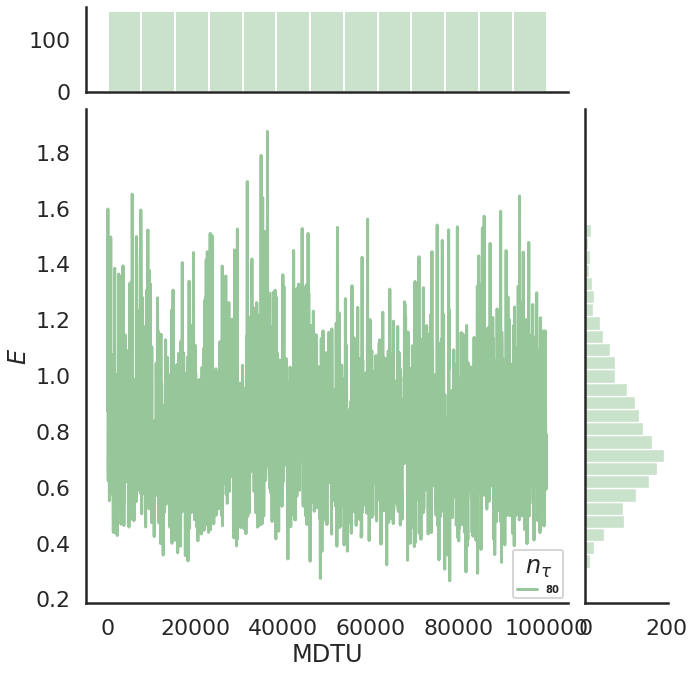

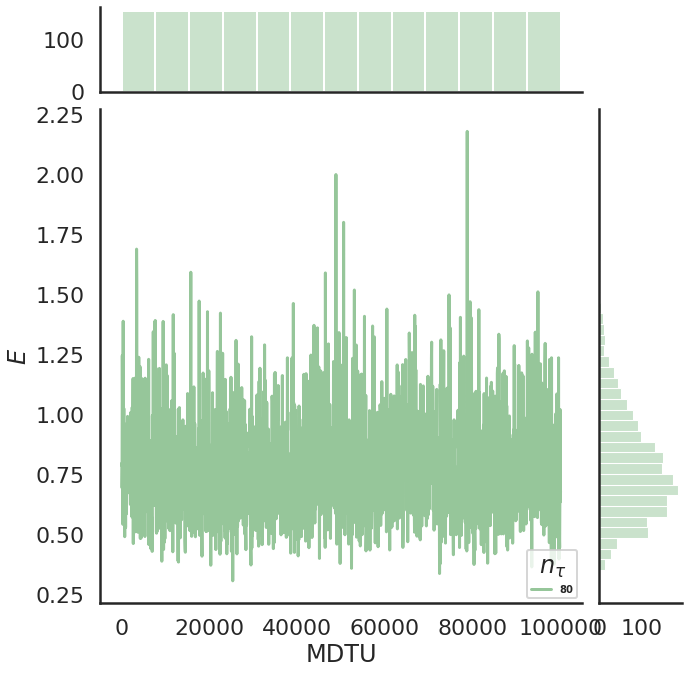

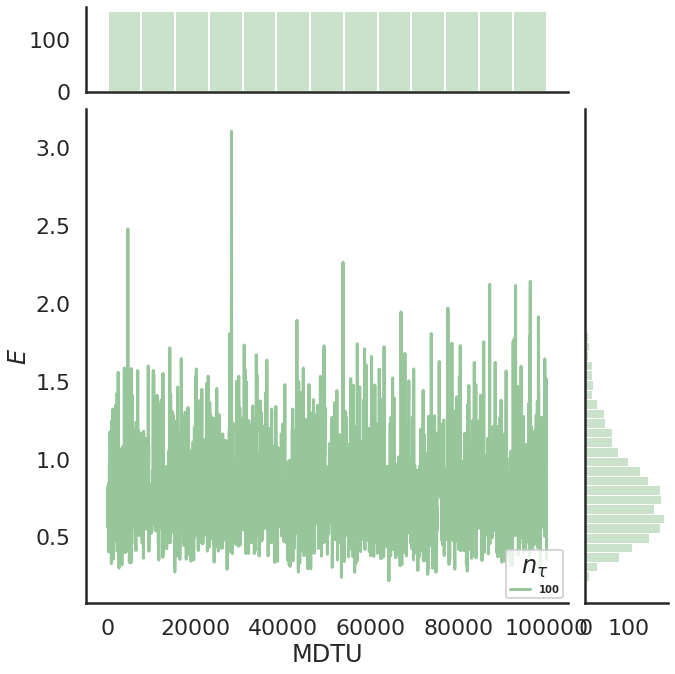

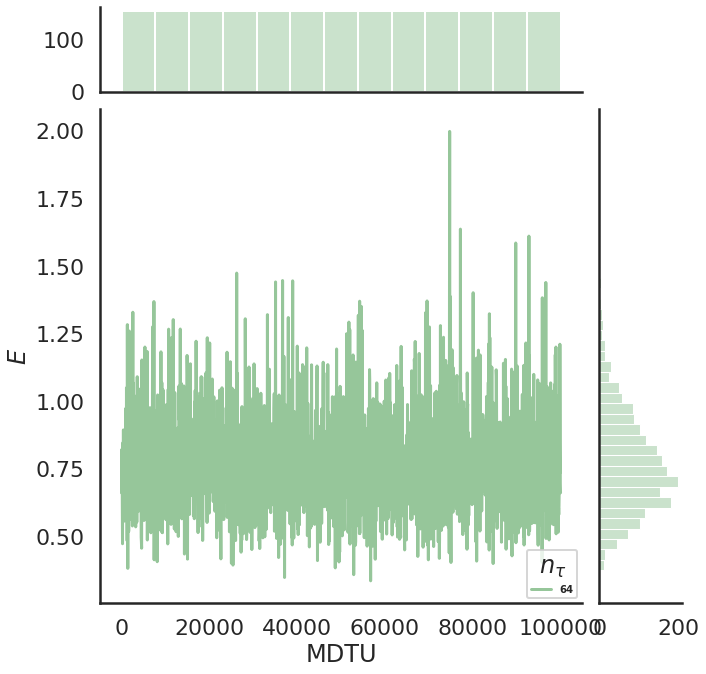

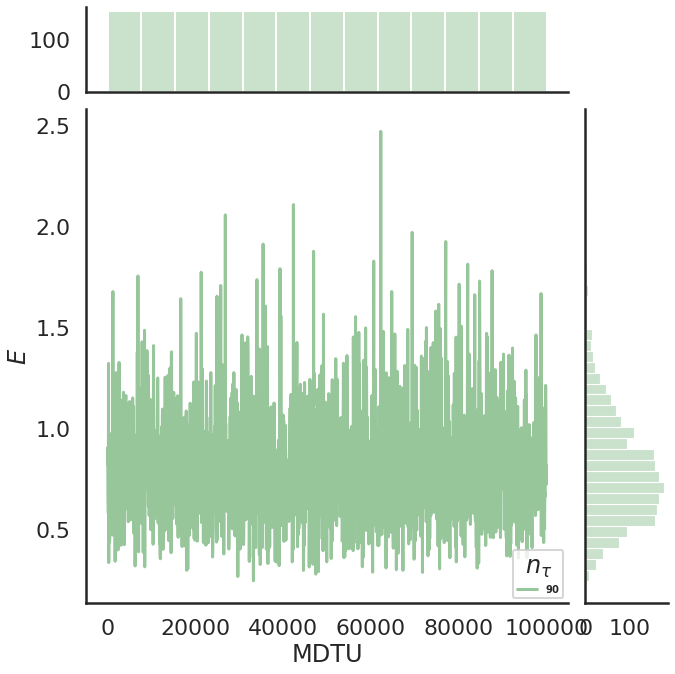

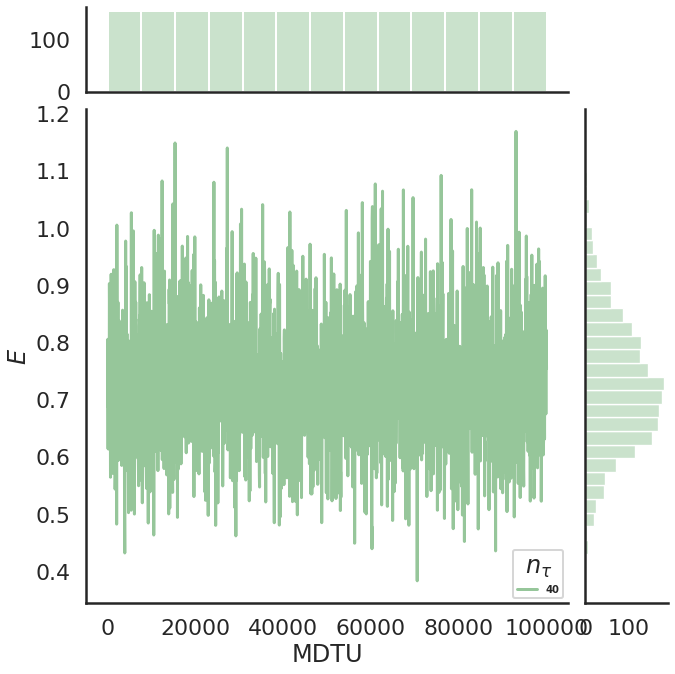

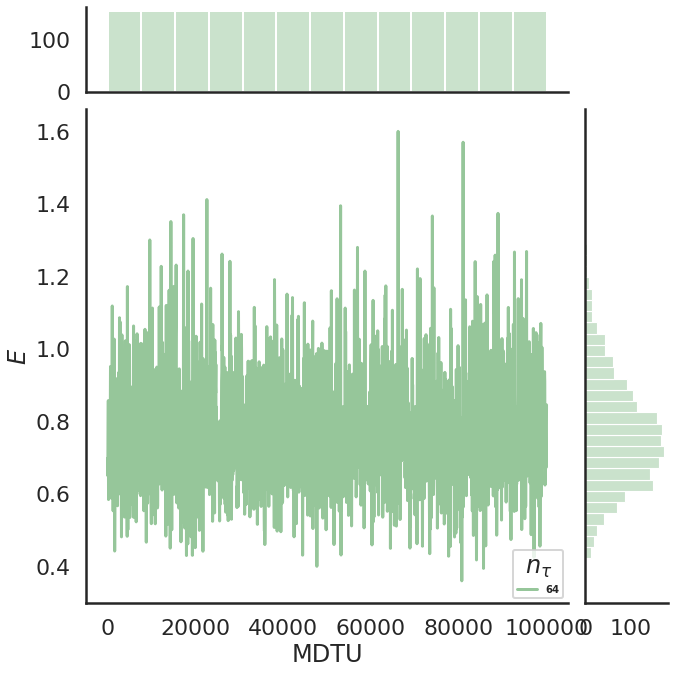

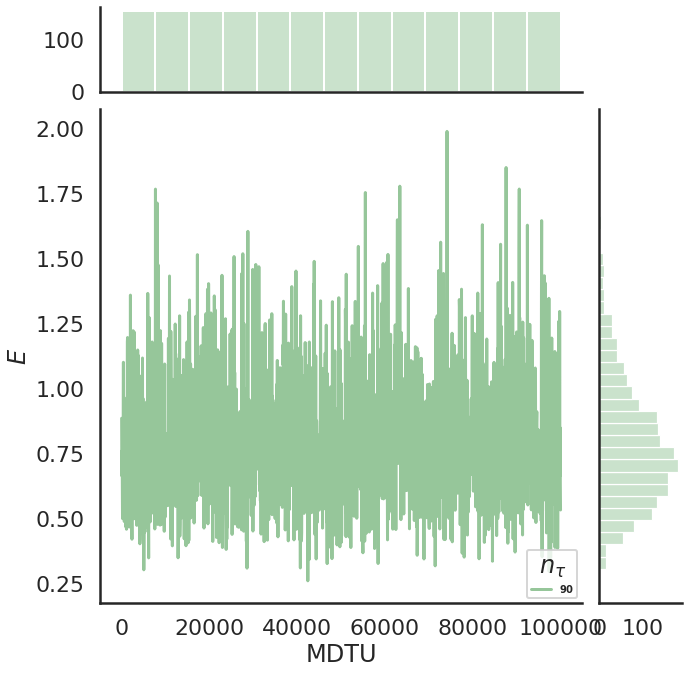

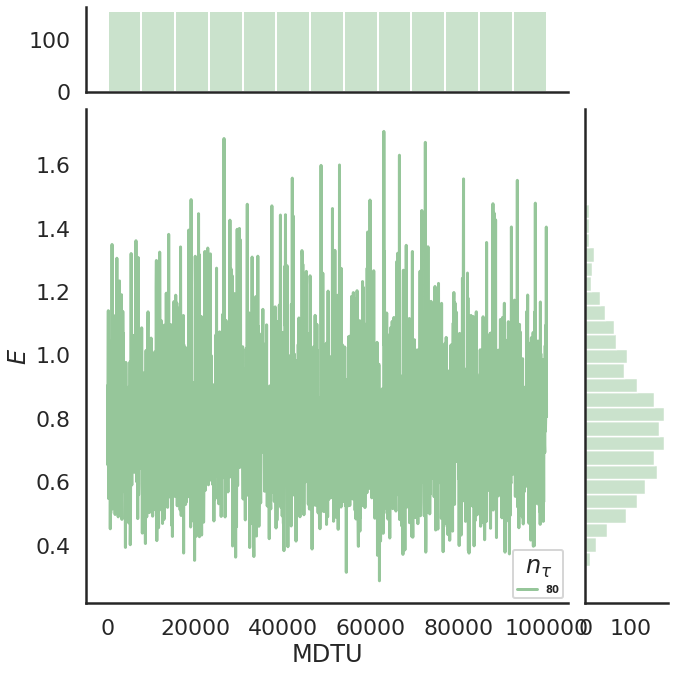

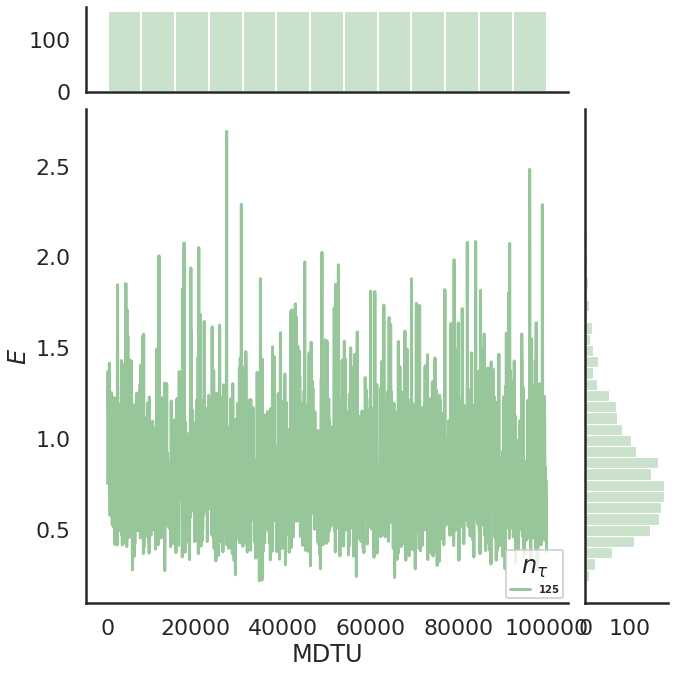

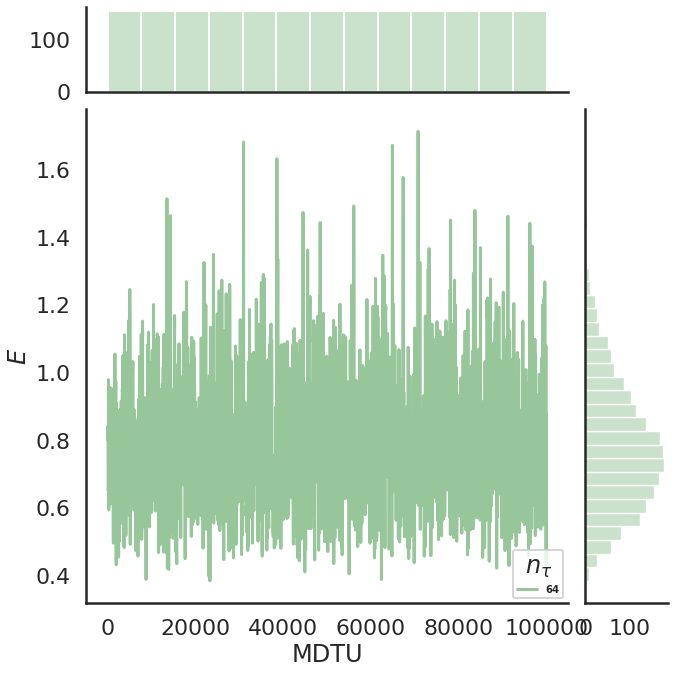

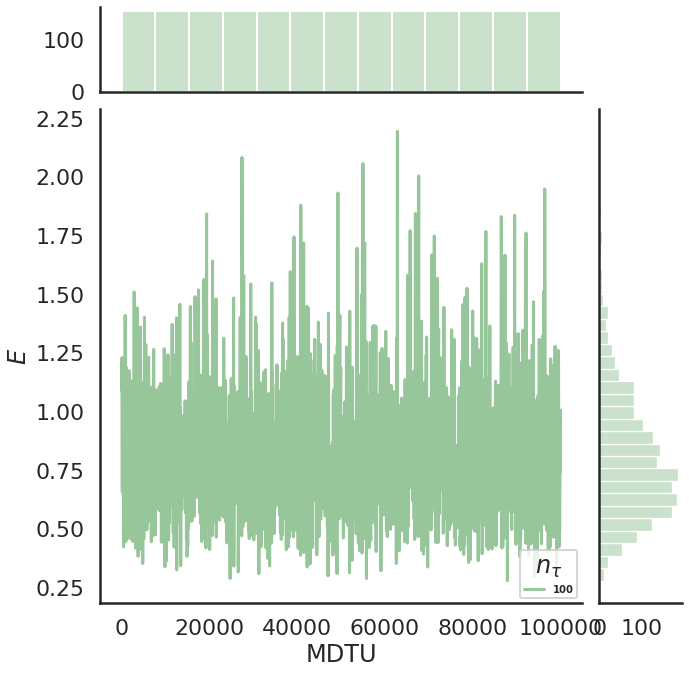

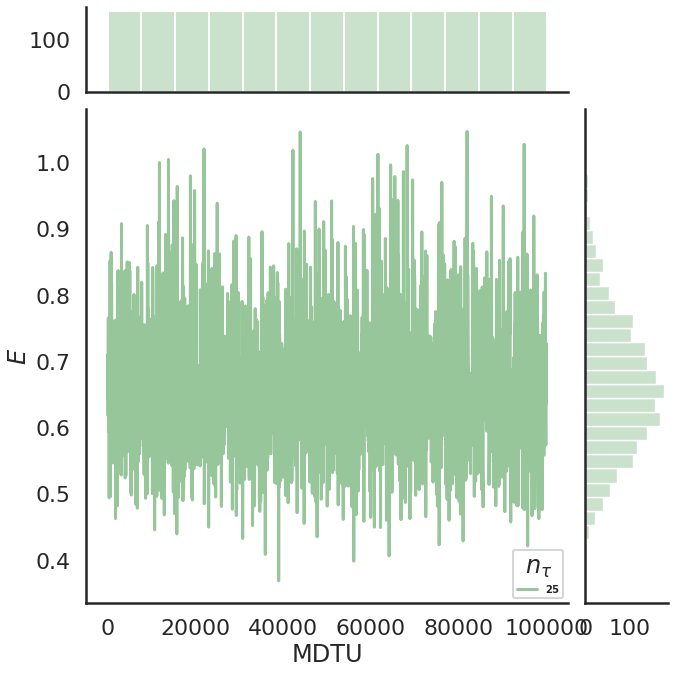

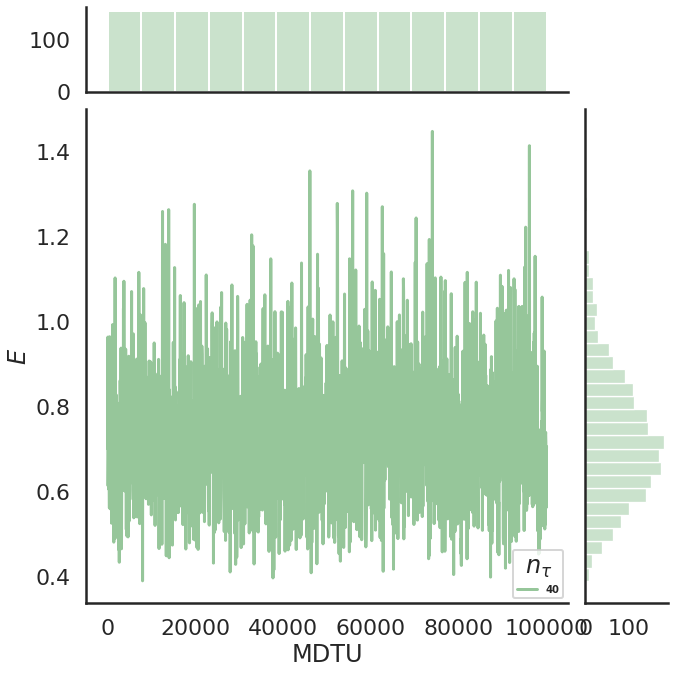

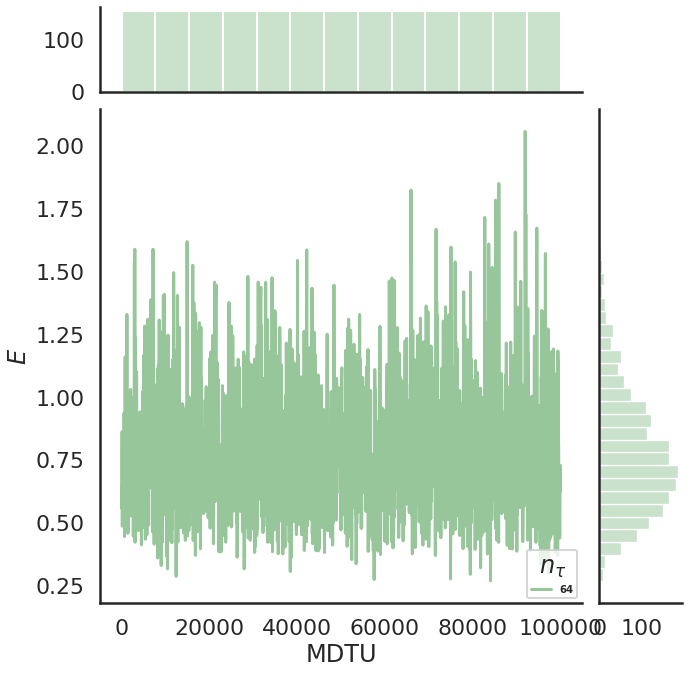

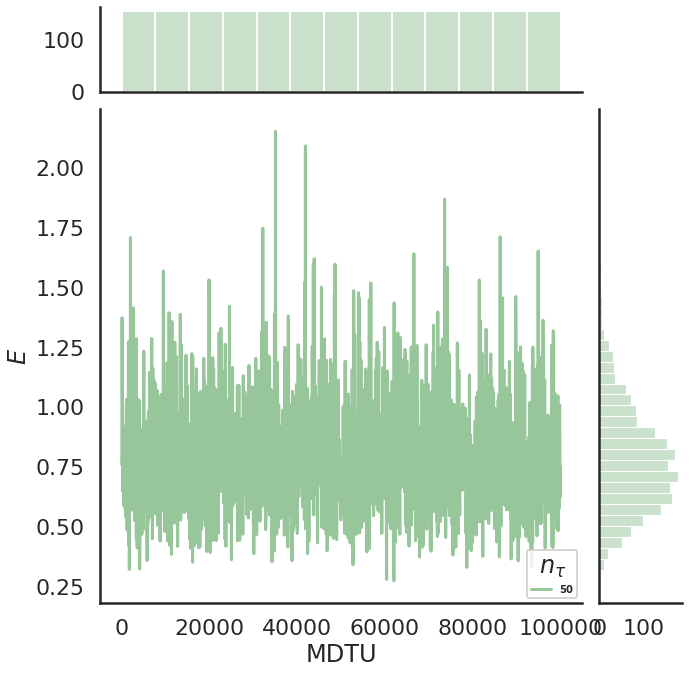

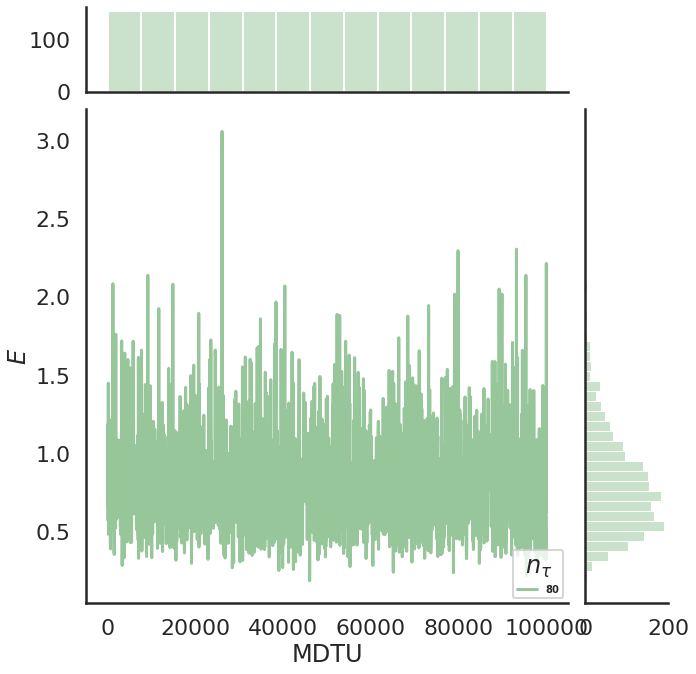

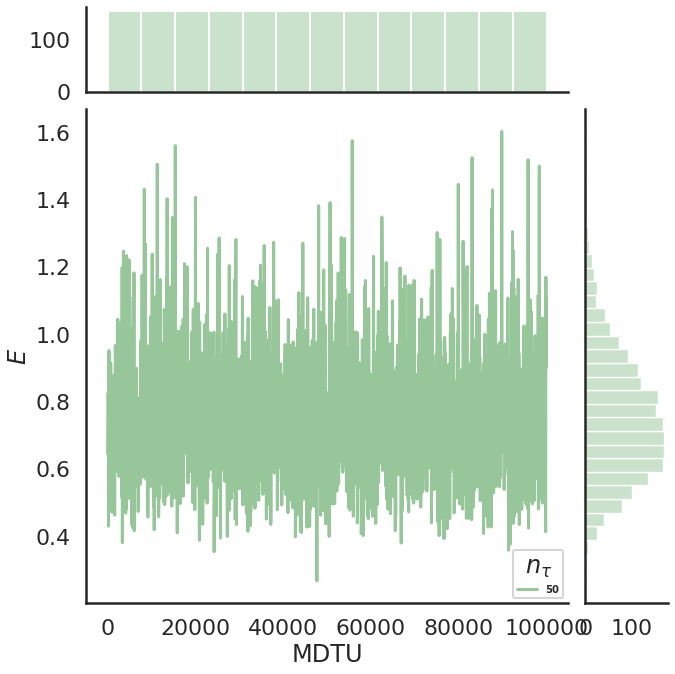

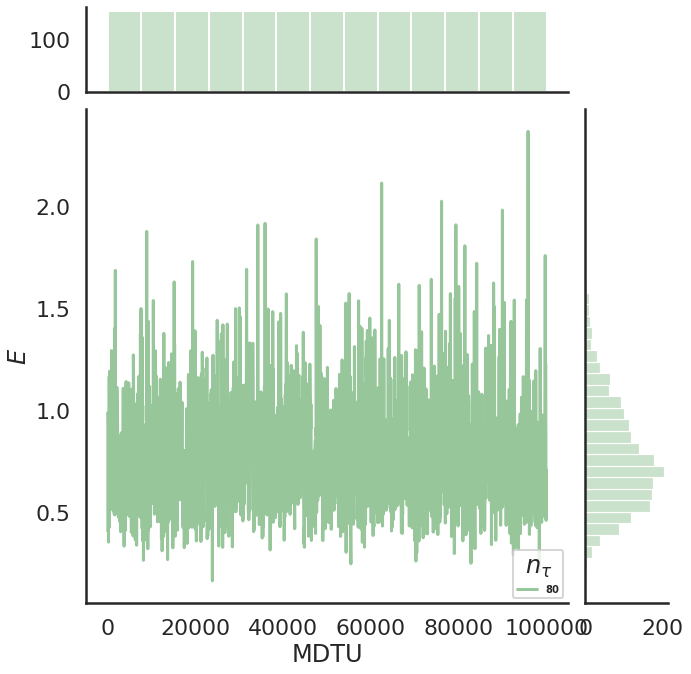

In [9]:
from pathlib import Path
runs = Path("../../lattice/improv_runs/bmn2_su2_g05")
for run in runs.rglob("l*/t*"):
    print(f"{run}")
    make_joint_plot_e_mdtu(run=str(run))

# Plot of the energy at fixed $n_t$

We plot the energy distribution of a MCMC run at fixed $n_t$ and for different temperatures $T$

In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_context("paper") # scale elements up or down in size

## Select a specific run

A run is at fixed 't Hooft coupling $\lambda$ and fixed gauge group rank $N$.

We choose SU(3) and $\lambda = 0.5$

In [138]:
# possible temperatures
Ts = ["04", "035", "03", "025", "02", "015", "01", "005", "0025"]
# possible n_t
Ls = ["16", "24", "32", "48", "64", "96", "128", "192"]
# possible cut in units of MDTU
cut =  100 # thermalization cut
# possible gauge group rank
N = 3
# possible 't Hoof coupling ["05", "10", "20"]
G = ["05", "10", "20"]
datarun = f"../../lattice/improv_runs/bmn2_su{N}_g{G[0]}"

In [139]:
# choose n_t
Nt = Ls[0]

## Get data from `HDF5` file

We need to get the energy observable for each of the temperatures at fixed $n_t$

In [140]:
# list where we save the energy of each temperature
energies = []
# list where we save the temperatures
temperatures = []

In [141]:
# loop over temperatures
for T in Ts:
    filename = f"{datarun}/l{Nt}/t{T}/data.h5"
    data = pd.read_hdf(filename, "mcmc_obs")
    # append to lists
    energies.append(data.e.values * float(N)**2)
    temperatures.append(data.temperature.values)

In [142]:
energies = np.concatenate(energies, axis=None)
temperatures = np.concatenate(temperatures, axis=None)
assert energies.shape == temperatures.shape

### Make a dataframe 

We need this to be able to use `seaborn` efficiently

In [143]:
df = pd.DataFrame(dict(t=temperatures, e=energies))

In [144]:
df.head()

,t,e
0,0.4,7.224978
1,0.4,13.290260
2,0.4,9.625114
3,0.4,6.523245
4,0.4,5.957012


In [145]:
df.shape

(10000, 2)

In [44]:
df.sample(6)

,t,e
5852,0.25,6.163709
2200,0.10,4.583634
3184,0.15,7.081130
9103,0.40,6.361814
7410,0.35,7.314829
5363,0.25,8.530142


In [146]:
t_order = list(df.t.unique())

## Make plot

Use the `FacetGrid` from `seaborn` following the example in the gallery [here](https://seaborn.pydata.org/examples/kde_ridgeplot.html)

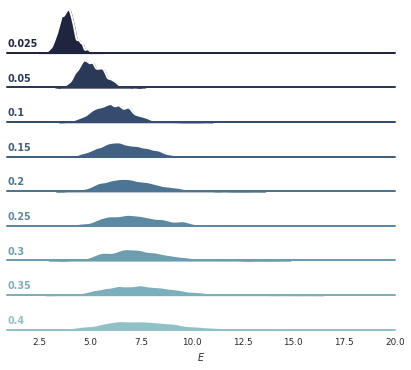

In [150]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(9, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="t", hue="t", hue_order=t_order, aspect=10, height=.6, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "e",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "e", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "e")
g.set_xlabels(r"$E$")
# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [36]:
# save figure
g.savefig(f"../figures/bmn2_su{N[1]}_g{G[0]}_l{Nt}_energy-kde_allT.pdf")

## Define a function to plot on each $n_t$

We want to make the plot above for each $n_t$. For this we define a plotting function that created the dataframe and save the facet plot with the energy densities

In [153]:
def make_kde_plot(
    Nt: str,
    Ts: list = ["04", "035", "03", "025", "02", "015", "01", "005", "0025"],
    run: str = "../../lattice/improv_runs/bmn2_su3_g05",
    outputdir: str = "../figures",
):
    # list where we save the energy of each temperature
    energies = []
    # list where we save the temperatures
    temperatures = []
    # loop over temperatures
    for T in Ts:
        try:
            filename = f"{run}/l{Nt}/t{T}/data.h5"
            data = pd.read_hdf(filename, "mcmc_obs")
            # append to lists
            energies.append(data.e.values * float(N) ** 2)
            temperatures.append(data.temperature.values)
        except (ValueError, FileNotFoundError) as e:
            print(f"{e} . Skipping...")
    energies = np.concatenate(energies, axis=None)
    temperatures = np.concatenate(temperatures, axis=None)
    assert energies.shape == temperatures.shape
    df = pd.DataFrame(dict(t=temperatures, e=energies))

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(len(Ts), rot=-0.25, light=0.7)
    g = sns.FacetGrid(
        df, row="t", hue="t", hue_order=t_order, aspect=10, height=0.6, palette=pal
    )

    # Draw the densities in a few steps
    g.map(
        sns.kdeplot,
        "e",
        bw_adjust=0.5,
        clip_on=False,
        fill=True,
        alpha=1,
        linewidth=1.5,
    )
    g.map(sns.kdeplot, "e", clip_on=False, color="w", lw=2, bw_adjust=0.5)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(
            0,
            0.2,
            label,
            fontweight="bold",
            color=color,
            ha="left",
            va="center",
            transform=ax.transAxes,
        )

    g.map(label, "e")
    g.set_xlabels(r"$E$")
    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-0.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)

    # save figure
    g.savefig(f"{outputdir}/{run.split('/')[-1]}_l{Nt}_energy-kde_allT.pdf")


Call the function for each $n_t$

L=16.0
File ../../lattice/improv_runs/bmn2_su2_g05/l16/t035/data.h5 does not exist . Skipping...
File ../../lattice/improv_runs/bmn2_su2_g05/l16/t0025/data.h5 does not exist . Skipping...
L=24.0
File ../../lattice/improv_runs/bmn2_su2_g05/l24/t035/data.h5 does not exist . Skipping...
File ../../lattice/improv_runs/bmn2_su2_g05/l24/t0025/data.h5 does not exist . Skipping...
L=32.0
File ../../lattice/improv_runs/bmn2_su2_g05/l32/t035/data.h5 does not exist . Skipping...
File ../../lattice/improv_runs/bmn2_su2_g05/l32/t0025/data.h5 does not exist . Skipping...
L=48.0
File ../../lattice/improv_runs/bmn2_su2_g05/l48/t035/data.h5 does not exist . Skipping...
File ../../lattice/improv_runs/bmn2_su2_g05/l48/t0025/data.h5 does not exist . Skipping...
L=64.0
File ../../lattice/improv_runs/bmn2_su2_g05/l64/t035/data.h5 does not exist . Skipping...
File ../../lattice/improv_runs/bmn2_su2_g05/l64/t0025/data.h5 does not exist . Skipping...
L=96.0
File ../../lattice/improv_runs/bmn2_su2_g05/l96/t035/

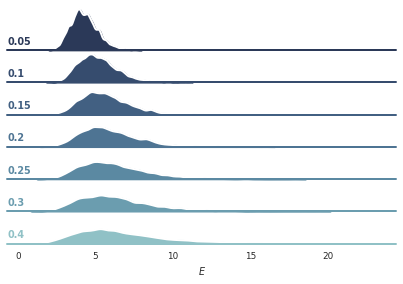

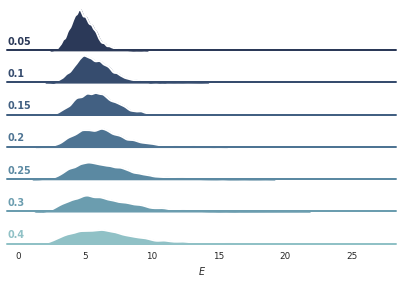

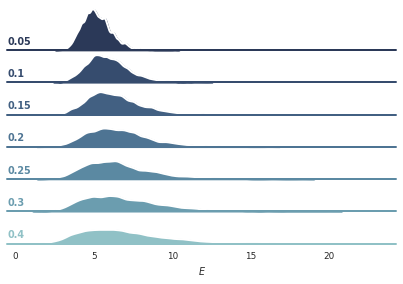

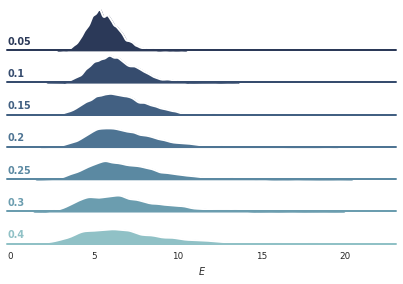

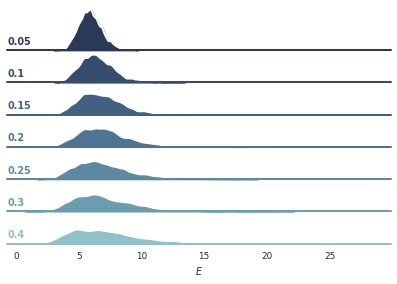

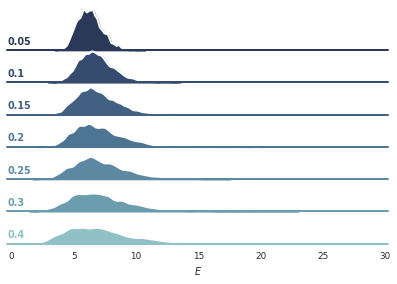

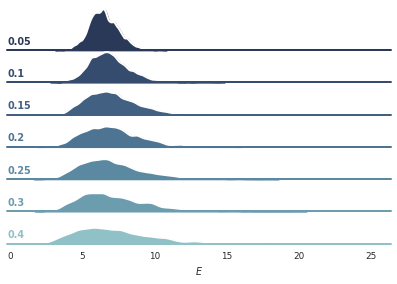

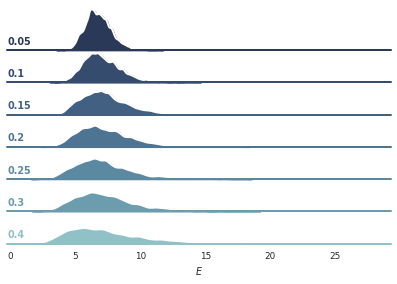

In [159]:
run = "../../lattice/improv_runs/bmn2_su2_g05"
for Nt in Ls:
    print(f"L={float(Nt)}")
    make_kde_plot(Nt, run=run)